In [1]:
import torch
from torch.utils.data import DataLoader
import os
import numpy as np
import torchio as tio
import monai
from monai.networks.nets import Unet
from sklearn.model_selection import train_test_split
from brain_stroke_ct.utilities import *
from tqdm.notebook import tqdm
from dpipe.im.slices import iterate_axis
from skimage.measure import label   

ModuleNotFoundError: No module named 'brain_stroke_ct'

# Dataset

In [2]:
path = '/ayb/vol4/perfusion_ct/stroke/'
subjects = list(range(99))
train, test = train_test_split(subjects)

transforms = tio.Compose([
    tio.Lambda(lambda x: torch.clamp(x, 0, 80), types_to_apply=tio.INTENSITY),
    tio.ToCanonical(),
    tio.RandomAffine(degrees=(0, 0, 30), image_interpolation='bspline'),
])


In [3]:
def img_reader(path):
    return (nib_load(path, np.int16), np.eye(4))

def brn_reader(path):
    return (nib_load(path, np.int8), np.eye(4))


def collect_subjects(subject_list):
    data = []
    for i in subject_list:
        subject = tio.Subject(
            img=tio.ScalarImage(path=os.path.join(path, str(i), 'image.nii.gz'), reader=img_reader),
            brn=tio.LabelMap(path=os.path.join(path, str(i), 'brain.nii.gz'), reader=brn_reader)
        )
        data.append(subject)
    return data
train_set = tio.SubjectsDataset(collect_subjects(train), transforms)
test_set = tio.SubjectsDataset(collect_subjects(test))

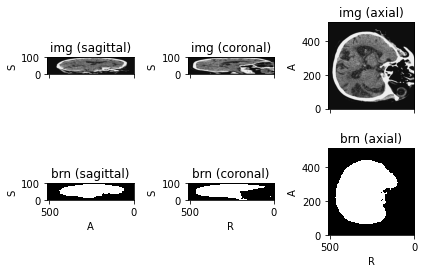

In [4]:
train_set[0].plot()

# Patches

In [5]:
train_queue = tio.Queue(
    subjects_dataset=train_set,
    max_length=30,
    samples_per_volume=30,
    sampler=tio.sampler.LabelSampler(
        patch_size=(512, 512, 1), 
        label_name='brn',
        label_probabilities={0:0.05, 1:0.95}
    )
)

test_queue = tio.Queue(
    subjects_dataset=test_set,
    max_length=30,
    samples_per_volume=30,
    sampler=tio.sampler.LabelSampler(
        patch_size=(512, 512, 1), 
        label_name='brn',
        label_probabilities={0:0.05, 1:0.95}
    )
)

train_loader = DataLoader(train_queue, batch_size=2, num_workers=8)
test_loader = DataLoader(test_queue, batch_size=1, num_workers=8)

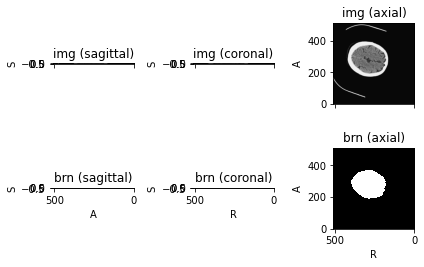

torch.Size([1, 512, 512, 1])


In [6]:
for i in train_queue:
    i.plot()
    print(i['img'][tio.DATA].shape)
    break

# Net

In [7]:
class Model(torch.nn.Module): 
    def __init__(self):
        super(Model, self).__init__()
        self.UNet = Unet(
            dimensions=2,
            in_channels=1,
            out_channels=1,
            channels=[32, 64, 128, 256, 512, 1024],
            strides=[2, 2, 2, 2, 2, 2],
            kernel_size=3,
            up_kernel_size=3,
        )
    def forward(self, x):
        x = self.UNet(x)
        return x

In [8]:
device = torch.device('cuda:2')
model = Model().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
dice = monai.losses.Dice()
dice_metric = monai.metrics.DiceMetric()
print(model(torch.rand(1, 1, 512, 512).to(device)).shape)

torch.Size([1, 1, 512, 512])


In [16]:
def train_step(loader, model, criterion, optimizer):
    epoch_loss = 0
    model.train()
    for batch in tqdm(loader):
        x = batch['img'][tio.DATA].squeeze(4).to(device)
        y = batch['brn'][tio.DATA].squeeze(4).to(device)
    
        y_hat = model(x)
        loss = criterion(y_hat, y)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return epoch_loss/len(loader)

def test_step(loader, model, criterion):
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader): 
            x = batch['img'][tio.DATA].squeeze(4).float().to(device)
            y = batch['brn'][tio.DATA].squeeze(4).float().to(device)
        
            y_hat = model(x)
            loss = criterion(y_hat, y)
            if not torch.isnan(loss): 
                epoch_loss += loss.item()
            else:
                epoch_loss += 0.5
            
    return epoch_loss/len(loader)

In [18]:
# num_epochs = 30
# for epoch in range(num_epochs):
#     print(f'Epoch: {epoch+1}')
    
#     train_loss = train_step(train_loader, model, criterion, optimizer)
#     print(f'Train loss = {train_loss}')
    
#     test_loss = test_step(test_loader, model, dice_metric)
#     print(f'Dice on test = {test_loss}')
    
#     torch.save(model.state_dict(), 'unet2d_patches.pth')

In [23]:
def inference(path, model, threshold = 0.8):
    model.eval()
    image = np.load(path)['image'].transpose(1, 2, 0) - 1024
    image = np.clip(image, 0, 80)
    result = np.zeros_like(image)
    
    for i, slc in enumerate(iterate_axis(image, 2)):
        slc = torch.from_numpy(slc).unsqueeze(0).to(device)
        with torch.no_grad():
            preds = model(slc.float().unsqueeze(0)) > threshold
        result[:, :, i] = preds.squeeze(0).squeeze(0).cpu().detach().numpy() 
    return result

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

In [20]:
from dpipe.im.visualize import slice3d

In [34]:
pth = '/ayb/vol4/perfusion_ct_dataset/027.npz'
model.load_state_dict(torch.load('unet2d_patches.pth'))
img = np.load(pth)['image'].transpose(1, 2, 0) - 1024
brn = inference(pth, model, 0.5)
slice3d(img, getLargestCC(brn))

FileNotFoundError: [Errno 2] No such file or directory: 'unet2d_patches.pth'

<All keys matched successfully>